In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler, abc_rejection_sampler2
import seaborn as sns
from scipy.stats import norm, lognorm

In [2]:
sns.set_theme()
beta_true = 0.15 # 0.15
alpha = 0.1
gamma = 0.05 # 0.05
prior_mu = -3
prior_sigma = 1
N = 100
T = 52
K = 30
heterogeneous = False

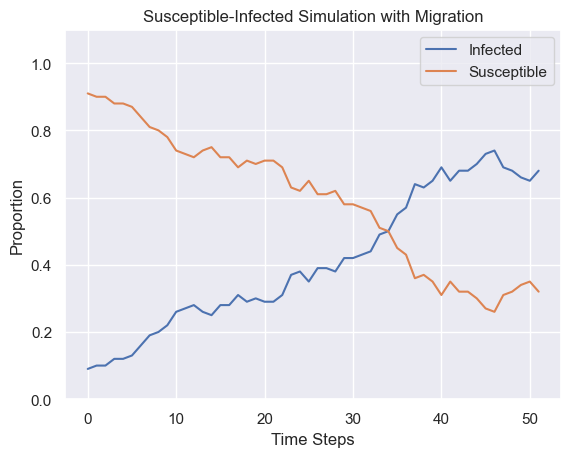

In [3]:
si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False)

x_o_raw = si_model.get_observed_data(29)
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

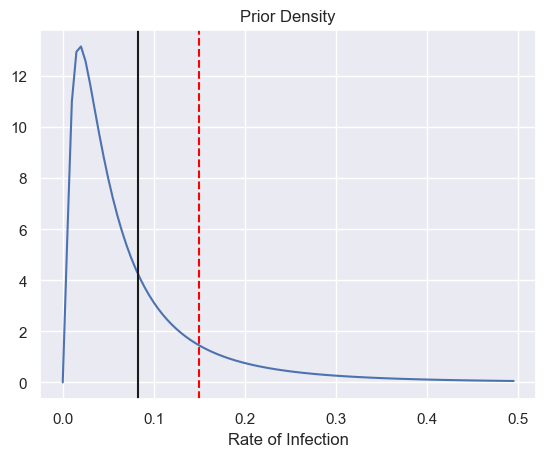

In [4]:
# visualize prior
np.random.seed(10)
x = np.arange(0, 0.5, 0.005)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma))
ax.set_xlabel("Rate of Infection")
ax.set_title(f"Prior Density")
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
plt.axvline(prior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--")
plt.show()

In [5]:
# np.random.seed(10)
# x = np.arange(-6, 0, 0.01)
# ax = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma))
# ax.set_xlabel("Rate of Infection")
# ax.set_title(f"Prior Density (Log Scale)")
# plt.axvline(prior_mu, color="k")
# plt.axvline(np.log(beta_true), color="red", linestyle="--")
# plt.show()

A reasonably well-calibrated prior: $P(\beta > \beta^*) = 0.15$.

### Prior Predictive Check

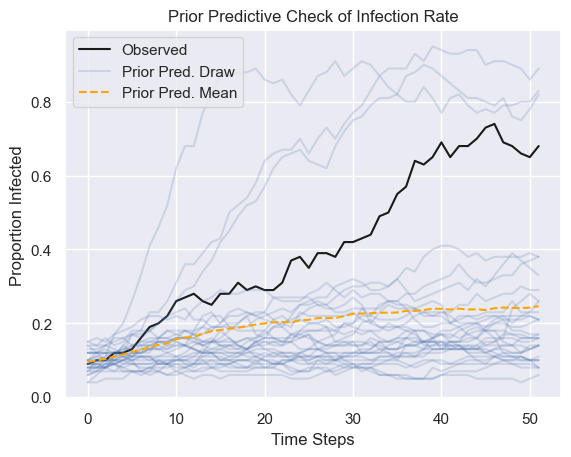

In [6]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=K, random_state=2))
prior_predictive = np.empty((K, T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                    n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    prior_predictive[i] =  np.array(x_rep)[0]
prp_mean = prior_predictive.mean(0)

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

## NPE

In [85]:
npe_results = {
    "Method": ["NPE"] * 6,
    "Simulations": [125, 250, 500, 1000, 2000, 4000],
    "mean": [-1.914, -1.972, -1.95, -2.013, -1.971, -1.985],
    "sd": [.162, .156, 0.139, .151, .125, .145]
}
df_npe = pd.DataFrame(npe_results)
df_npe["Posterior Mean"] = np.exp(df_npe["mean"] + df_npe["sd"]**2/2)
df_npe[".05"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.05))
df_npe[".95"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.95))

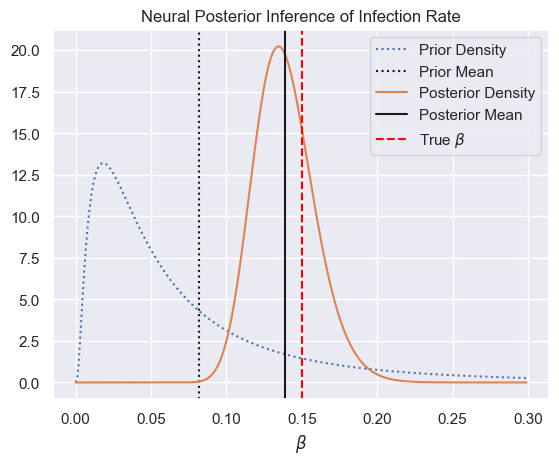

In [166]:
mu = df_npe["mean"].iloc[-1]
sigma = df_npe["sd"].iloc[-1]
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
plt.axvline(posterior_mean, color="k", label="Posterior Mean")
plt.axvline(beta_true, color="red", linestyle="--", label=r"True $\beta$")
ax.set_xlabel(r"$\beta$")
ax.set_title(f"Neural Posterior Inference of Infection Rate")
plt.legend()
plt.show()

In [167]:
posterior_mean

0.13883244564185623

In [168]:
prior_mean

0.0820849986238988

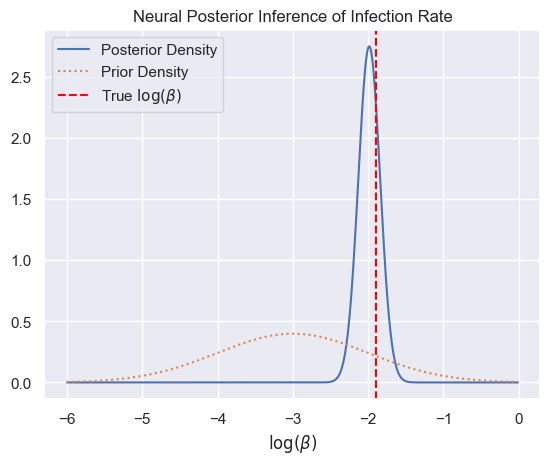

In [163]:
np.random.seed(10)
x = np.arange(-6., 0, 0.01)
ax = sns.lineplot(x=x, y=norm.pdf(x, mu, sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"$\log (\beta)$")
ax.set_title(f"Neural Posterior Inference of Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
# plt.axvline(prior_mu, color="k", linestyle=":")
# plt.axvline(mu, color="k")
plt.axvline(np.log(beta_true), color="red", linestyle="--", label=r"True $\log (\beta)$")
plt.legend()
plt.show()

## Posterior Predictive Checks

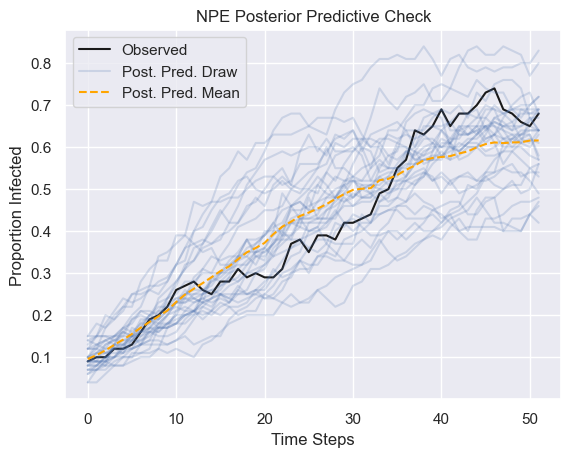

In [44]:
neural_posterior = norm(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("NPE Posterior Predictive Check")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

## ABC

In [65]:
# testing
eps = .01
summarize = True
si_model = SIModel(alpha, gamma, beta_true, 
                n_zones, prior_mu, prior_sigma, 
               N, T, summarize=summarize)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)
x_o = x_o.transpose(0, 1)
S = 100

posterior_sample, errors = abc_rejection_sampler(
    S, eps, prior_sampler, simulator, x_o, max_attempts=100000,
    summarize=summarize
    )
np.exp(posterior_sample).mean()

Time lapsed: 5.41 seconds
With tolerance 0.01, acceptance rate: 0.015810
Total number of attempts: 6,325


0.1263973

In [82]:
abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
abc_samples = []

args = [(False, [5, 2, 1, 0.5, 0.4]),
        (True, [0.5, 0.2, 0.1, 0.02, 0.01])]
for summarize, es in args:
    for epsilon in es:
        si_model = SIModel(alpha, gamma, beta_true, 
                        n_zones, prior_mu, prior_sigma, 
                       N, T, summarize=summarize)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data(29)
        x_o = x_o.transpose(0, 1)
        S = 100
        print(f"epsilon: {epsilon}")
        posterior_sample, errors = abc_rejection_sampler(
            S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
            summarize=summarize
            )
        print("***")
        abc_data["summarize"].append(summarize)
        abc_data["epsilon"].append(epsilon)
        abc_data["simulations"].append((errors > 0).sum())
        abc_samples.append(posterior_sample[:,0])

epsilon: 5
Time lapsed: 0.11 seconds
With tolerance 5, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 2
Time lapsed: 0.19 seconds
With tolerance 2, acceptance rate: 0.467290
Total number of attempts: 214
***
epsilon: 1
Time lapsed: 0.54 seconds
With tolerance 1, acceptance rate: 0.158479
Total number of attempts: 631
***
epsilon: 0.5
Time lapsed: 4.38 seconds
With tolerance 0.5, acceptance rate: 0.019257
Total number of attempts: 5,193
***
epsilon: 0.4
Time lapsed: 21.03 seconds
With tolerance 0.4, acceptance rate: 0.003992
Total number of attempts: 25,053
***
epsilon: 0.5
Time lapsed: 0.08 seconds
With tolerance 0.5, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 0.2
Time lapsed: 0.22 seconds
With tolerance 0.2, acceptance rate: 0.386100
Total number of attempts: 259
***
epsilon: 0.1
Time lapsed: 0.57 seconds
With tolerance 0.1, acceptance rate: 0.147710
Total number of attempts: 677
***
epsilon: 0.02
Time lapsed: 2.73 seconds
With tolerance

In [149]:
df_abc = pd.DataFrame(abc_data)

abc_posterior = np.array(abc_samples)
df_abc["Posterior Mean"] = np.exp(abc_posterior).mean(1)

df_abc[".05"] = np.quantile(np.exp(abc_posterior), 0.05, 1)
df_abc[".95"] = np.quantile(np.exp(abc_posterior), 0.95, 1)
df_abc["sd"] = abc_posterior.std(1)
df_abc["mean"] = abc_posterior.mean(1)
df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")
df_abc = df_abc.rename(columns={"simulations":"Simulations"})

In [150]:
df_results = pd.concat([df_npe, 
           df_abc[["Method", "Simulations", "Posterior Mean", ".05", ".95", "mean", "sd"]]])

In [120]:
npe = df_results[df_results["Method"] == "NPE"]
abc = df_results[df_results["Method"] == "ABC"]
abcs = df_results[df_results["Method"] == "ABC-S"]

In [121]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

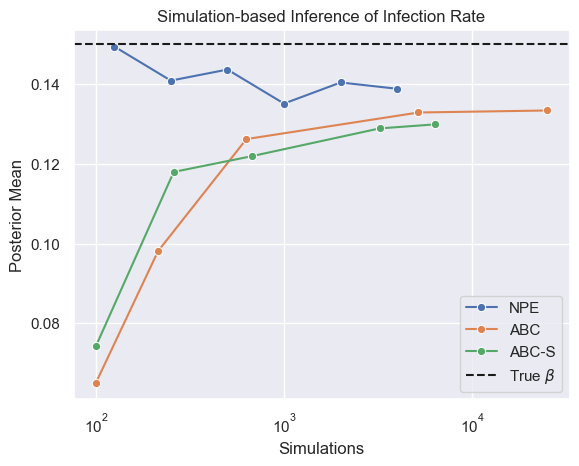

In [129]:
ax = sns.lineplot(df_results, x="Simulations", y="Posterior Mean", marker="o", hue="Method")
ax.axhline(y = 0.15, color="k", label=r"True $\beta$", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

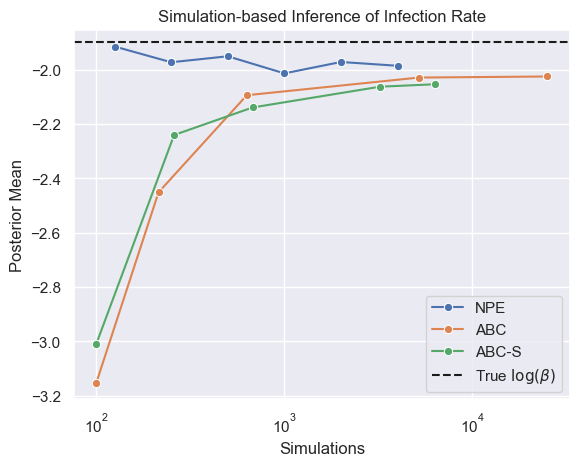

In [158]:
ax = sns.lineplot(df_results, x="Simulations", y="mean", marker="o", hue="Method")
ax.axhline(y = np.log(0.15), color="k", label=r"True $\log(\beta)$", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

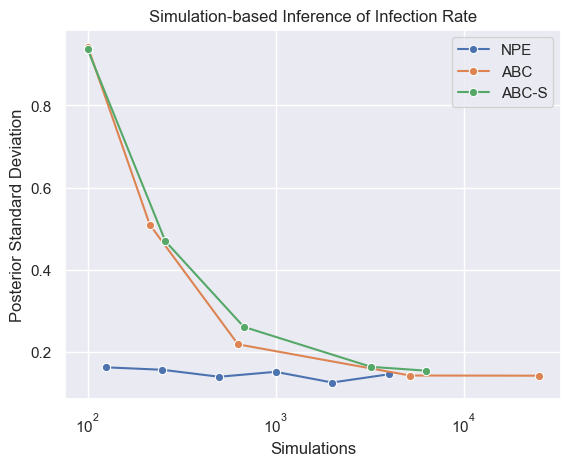

In [130]:
ax = sns.lineplot(df_results, x="Simulations", y="sd", marker="o", hue="Method")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Standard Deviation")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

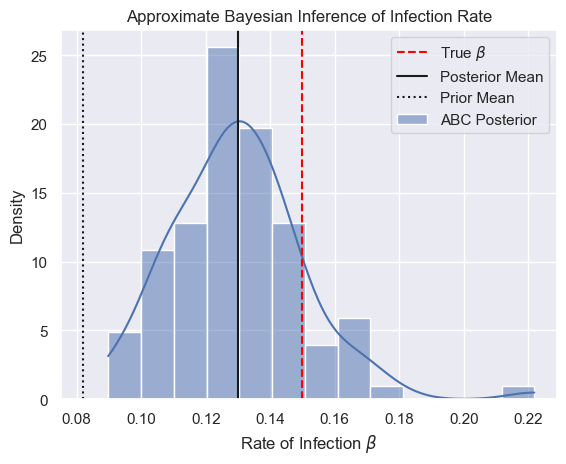

In [159]:
ax = sns.histplot(np.exp(abc_posterior[-1]), stat="density", kde=True, label="ABC Posterior")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(r"Approximate Bayesian Inference of Infection Rate")
plt.axvline(beta_true, color="red", linestyle="--", label=r"True $\beta$")
plt.axvline(np.exp(abc_posterior[-1]).mean(), color="k", label="Posterior Mean")
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
#x.get_legend().remove()
plt.legend()
plt.show()

### ABC PPC

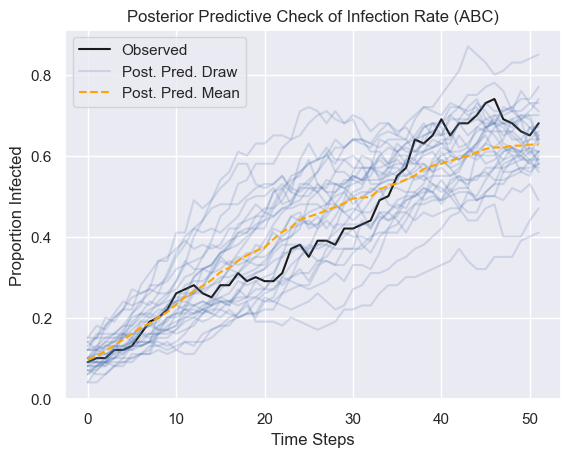

In [93]:
posterior_predictive_abc = np.empty((K, T))
for i in range(30):
    beta = np.exp(abc_posterior[-1][i])
    si_model = SIModel(alpha, gamma, beta, 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive_abc[i] =  np.array(x_rep)[0]
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

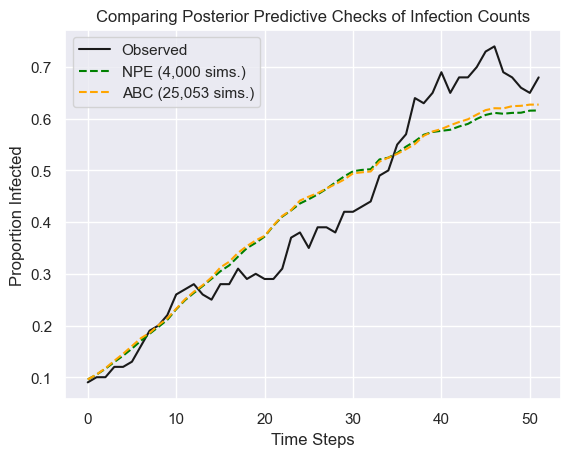

In [96]:
plt.plot(I_o, label="Observed", color="k")
plt.plot(pp_mean, label="NPE (4,000 sims.)", linestyle="--",
         color="green")
plt.plot(pp_mean_abc, label="ABC (25,053 sims.)", linestyle="--",
         color="orange")
plt.legend()
plt.title("Comparing Posterior Predictive Checks of Infection Counts")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

NPE posterior predictive mean is virtually identifical!

# Prior Strength 

In [35]:
# testing
for prior_sigma in 4,2,1,0.5,0.25:
    prior_mu = -2
    summarize = False
    si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=summarize)
    prior_sampler = lambda: si_model.sample_logbeta(1)
    simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
    x_o = si_model.get_observed_data(29)
    S = 500
    posterior_sample, errors = abc_rejection_sampler2(S, prior_sampler, simulator, x_o, summarize)
    accepted = posterior_sample[errors.argsort()[:100]]
    print(prior_sigma)
    print(accepted.mean(), accepted.std())
    print(np.exp(accepted).mean())

4
-2.0722751998901368 0.5141953831222603
0.14268644726618598
2
-2.0503327441215515 0.287187972158015
0.13401788286858138
1
-2.0587233889102934 0.20938645858195665
0.13037059843018425
0.5
-2.006075019836426 0.1621277862643427
0.13629922818823637
0.25
-2.0318924820423128 0.12241302213547792
0.13205620046718466


In [33]:
for prior_sigma in [4,2,1,0.5,0.25]:
    prior_mu = -2
    prior_sigma = 2
    eps = 1
    summarize = False
    si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=summarize)
    prior_sampler = lambda: si_model.sample_logbeta(1)
    simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
    x_o = si_model.get_observed_data(29)
    S = 100
    posterior_sample, errors = abc_rejection_sampler(
                S, eps, prior_sampler, simulator, x_o, max_attempts=30000,
                summarize=summarize
                )
    print(prior_sigma)
    print(posterior_sample.mean(), posterior_sample.std())
    print(np.exp(posterior_sample.mean()))

Time lapsed: 0.74 seconds
With tolerance 1, acceptance rate: 0.122549
Total number of attempts: 816
2
-2.0435112 0.2299121
0.12957296
Time lapsed: 0.79 seconds
With tolerance 1, acceptance rate: 0.109051
Total number of attempts: 917
2
-2.060451 0.20706764
0.1273965
Time lapsed: 0.71 seconds
With tolerance 1, acceptance rate: 0.120627
Total number of attempts: 829
2
-2.0888703 0.23984487
0.12382694
Time lapsed: 0.77 seconds
With tolerance 1, acceptance rate: 0.111235
Total number of attempts: 899
2
-2.0584652 0.2661679
0.12764972
Time lapsed: 0.80 seconds
With tolerance 1, acceptance rate: 0.107759
Total number of attempts: 928
2
-2.0737822 0.22720048
0.12570943
